# install libraries

In [ ]:
!pip install --upgrade pip
!pip install "snowflake-connector-python[pandas]" "snowflake-snowpark-python[pandas]" snowflake-snowpark-python==1.9.0 fosforio fosforml numpy pandas matplotlib scikit-learn xgboost seaborn python-dateutil tqdm holidays
!pip install --upgrade --q snowflake-snowpark-python==1.9.0
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15

# Import helper libraries

In [1]:
from fosforio import snowflake
from fosforml import *
from fosforml.constants import MLModelFlavours
from fosforio import get_dataframe
from matplotlib import pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import warnings; warnings.simplefilter('ignore')
from joblib import dump, load
import requests
from tqdm import tqdm
import time
import calendar

from time import sleep
import configparser
from dateutil.relativedelta import relativedelta
import datetime
from dateutil.easter import easter
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit

%matplotlib inline

Connection manager service url initialised to http://fdc-project-manager:80/project-manager
If you need to update its value then update the variable CONNECTION_MANAGER_BASE_URL in os env.


/tmp/pip_packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Matplotlib created a temporary cache directory at /tmp/matplotlib-lbf829qe because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# connect to snowflake

In [2]:
snowflake.get_connection(connection_name="TTH_REV_OPT_CXN")
data = get_dataframe("BOOKINGS_TRANSFORMED")
data

Connection object created: <snowflake.connector.connection.SnowflakeConnection object at 0x7f341c645d60>
Please close the connection after use!
Reading dataframe from snowflake native connector


,ARRIVAL_DATE_TRANSFORMED,RESERVATION_STATUS_DATE_TRANSFORMED,HOTEL,IS_CANCELED,LEAD_TIME,ARRIVAL_DATE_YEAR,MONTH,ARRIVAL_DATE_WEEK_NUMBER,ARRIVAL_DATE_DAY_OF_MONTH,EXPECTED_ARRIVAL_DATE,RESERVATION_STATUS,RESERVATION_STATUS_DATE,TOTAL_STAY_NIGHTS,TALLY_DAYS,STAYS_IN_WEEKEND_NIGHTS,STAYS_IN_WEEK_NIGHTS,ADULTS,CHILDREN,BABIES,TOTAL_GUESTS,AVG_ROOMS_PER_NIGHT,TOTAL_ROOM_NIGHTS,MEAL,COUNTRY,MARKET_SEGMENT,DISTRIBUTION_CHANNEL,PREVIOUS_CANCELLATIONS,PREVIOUS_BOOKINGS_NOT_CANCELED,RESERVED_ROOM_TYPE,ASSIGNED_ROOM_TYPE,DEPOSIT_TYPE,DAYS_IN_WAITING_LIST,CUSTOMER_TYPE,ADR
0,2021-07-16,2020-10-17,City Hotel,1,272,2021,7,29,16,16-07-2021,Canceled,17-10-2020,2,0.272,0,2,2,0,0,2,1,2,BB,PRT,Groups,TA/TO,1,0,A,A,No Deposit,0,Transient.Party,62.80
1,2021-08-20,2020-10-17,City Hotel,1,307,2021,8,34,20,20-08-2021,Canceled,17-10-2020,2,0.307,0,2,2,0,0,2,1,2,BB,PRT,Groups,TA/TO,1,0,A,A,No Deposit,0,Transient.Party,62.80
2,2021-07-02,2020-10-17,City Hotel,1,258,2021,7,27,2,02-07-2021,Canceled,17-10-2020,2,0.258,0,2,2,0,0,2,1,2,BB,PRT,Groups,TA/TO,1,0,A,A,No Deposit,0,Transient.Party,62.80
3,2021-08-20,2020-10-17,City Hotel,1,307,2021,8,34,20,20-08-2021,Canceled,17-10-2020,2,0.307,0,2,2,0,0,2,1,2,BB,PRT,Groups,TA/TO,1,0,A,A,No Deposit,0,Transient.Party,62.80
4,2021-07-23,2020-10-17,City Hotel,1,279,2021,7,30,23,23-07-2021,Canceled,17-10-2020,2,0.279,0,2,2,0,0,2,1,2,BB,PRT,Groups,TA/TO,1,0,A,A,No Deposit,0,Transient.Party,62.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109706,2023-08-24,2023-09-10,Resort Hotel,0,269,2023,8,34,24,24-08-2023,Check.Out,10-09-2023,17,17.000,4,13,2,0,0,2,1,17,BB,GBR,Offline TA/TO,TA/TO,0,0,D,D,No Deposit,0,Contract,84.80
109707,2023-08-31,2023-09-10,Resort Hotel,0,212,2023,8,35,31,31-08-2023,Check.Out,10-09-2023,10,10.000,2,8,2,1,0,3,1,10,BB,GBR,Offline TA/TO,TA/TO,0,0,A,A,No Deposit,0,Transient,89.75
109708,2023-08-29,2023-09-12,Resort Hotel,0,204,2023,8,35,29,29-08-2023,Check.Out,12-09-2023,14,14.000,4,10,2,0,0,2,1,14,BB,IRL,Direct,Direct,0,0,E,E,No Deposit,0,Transient,153.57
109709,2023-08-31,2023-09-14,Resort Hotel,0,161,2023,8,35,31,31-08-2023,Check.Out,14-09-2023,14,14.000,4,10,2,0,0,2,1,14,HB,DEU,Offline TA/TO,TA/TO,0,0,A,A,No Deposit,0,Transient,99.06


In [3]:
data.columns = [x.lower() for x in data.columns]

In [4]:
data.columns

Index(['arrival_date_transformed', 'reservation_status_date_transformed',
       'hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'expected_arrival_date', 'reservation_status',
       'reservation_status_date', 'total_stay_nights', 'tally_days',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'total_guests', 'avg_rooms_per_night', 'total_room_nights',
       'meal', 'country', 'market_segment', 'distribution_channel',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr'],
      dtype='object')

# removing Canceletions and no-shows and keep City hotel data only


In [5]:
df = data[(data['is_canceled'] == 0) & (data['reservation_status'] !='No-Show')] 
df

,arrival_date_transformed,reservation_status_date_transformed,hotel,is_canceled,lead_time,arrival_date_year,month,arrival_date_week_number,arrival_date_day_of_month,expected_arrival_date,reservation_status,reservation_status_date,total_stay_nights,tally_days,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,total_guests,avg_rooms_per_night,total_room_nights,meal,country,market_segment,distribution_channel,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,deposit_type,days_in_waiting_list,customer_type,adr
2388,2021-07-01,2021-07-02,Resort Hotel,0,0,2021,7,27,1,01-07-2021,Check.Out,02-07-2021,1,1.0,0,1,2,0,0,2,1,1,BB,FRA,Corporate,Corporate,0,0,A,G,No Deposit,0,Transient,107.42
2410,2021-07-01,2021-07-02,Resort Hotel,0,1,2021,7,27,1,01-07-2021,Check.Out,02-07-2021,1,1.0,0,1,1,0,0,1,1,1,BB,PRT,Corporate,Corporate,0,4,A,B,No Deposit,0,Transient,134.00
2425,2021-07-01,2021-07-02,Resort Hotel,0,2,2021,7,27,1,01-07-2021,Check.Out,02-07-2021,1,1.0,0,1,1,0,0,1,1,1,BB,PRT,Online TA,TA/TO,0,1,A,C,No Deposit,0,Transient,4.00
2427,2021-07-01,2021-07-02,Resort Hotel,0,4,2021,7,27,1,01-07-2021,Check.Out,02-07-2021,1,1.0,0,1,1,0,0,1,1,1,BB,PRT,Corporate,Corporate,0,4,A,C,No Deposit,0,Transient,134.00
2561,2021-07-01,2021-07-02,Resort Hotel,0,13,2021,7,27,1,01-07-2021,Check.Out,02-07-2021,1,1.0,0,1,1,0,0,1,1,1,BB,GBR,Corporate,Corporate,0,0,A,A,No Deposit,0,Transient,75.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109706,2023-08-24,2023-09-10,Resort Hotel,0,269,2023,8,34,24,24-08-2023,Check.Out,10-09-2023,17,17.0,4,13,2,0,0,2,1,17,BB,GBR,Offline TA/TO,TA/TO,0,0,D,D,No Deposit,0,Contract,84.80
109707,2023-08-31,2023-09-10,Resort Hotel,0,212,2023,8,35,31,31-08-2023,Check.Out,10-09-2023,10,10.0,2,8,2,1,0,3,1,10,BB,GBR,Offline TA/TO,TA/TO,0,0,A,A,No Deposit,0,Transient,89.75
109708,2023-08-29,2023-09-12,Resort Hotel,0,204,2023,8,35,29,29-08-2023,Check.Out,12-09-2023,14,14.0,4,10,2,0,0,2,1,14,BB,IRL,Direct,Direct,0,0,E,E,No Deposit,0,Transient,153.57
109709,2023-08-31,2023-09-14,Resort Hotel,0,161,2023,8,35,31,31-08-2023,Check.Out,14-09-2023,14,14.0,4,10,2,0,0,2,1,14,HB,DEU,Offline TA/TO,TA/TO,0,0,A,A,No Deposit,0,Transient,99.06


In [6]:
df.groupby(['hotel','market_segment','reserved_room_type']).agg({'adr':'mean','reservation_status_date_transformed':'count'})


adr  \
hotel        market_segment reserved_room_type               
City Hotel   Aviation       A                    96.503608   
                            D                   107.713951   
                            E                   159.250000   
             Complementary  A                    45.840909   
                            D                    25.000000   
                            E                    55.000000   
             Corporate      A                    80.056789   
                            D                   100.689130   
                            E                   114.798295   
             Direct         A                   107.756930   
                            D                   132.383522   
                            E                   164.454444   
             Groups         A                    86.892940   
                            D                    87.340441   
                            E                    80.000000   
             Offline TA/TO  A                    91.273987   
                            D                    90.301959   
                            E                   133.371644   
             Online TA      A                   106.477667   
                            D                   136.476930   
                            E                   169.355059   
Resort Hotel Complementary  A                    21.226923   
                            D                    41.216667   
                            E                     7.333333   
             Corporate      A                    49.700175   
                            D                    67.398478   
                            E                    61.588545   
             Direct         A                    84.610434   
                            D                   116.982329   
                            E                   118.980300   
             Groups         A                    67.339807   
                            D                    74.881529   
                            E                    87.092028   
             Offline TA/TO  A                    64.219800   
                            D                    85.303927   
                            E                    97.511393   
             Online TA      A                    90.874218   
                            D                   113.257346   
                            E                   117.962164   

                                                reservation_status_date_transformed  
hotel        market_segment reserved_room_type                                       
City Hotel   Aviation       A                                                    97  
                            D                                                    81  
                            E                                                     2  
             Complementary  A                                                    22  
                            D                                                     4  
                            E                                                     2  
             Corporate      A                                                  2074  
                            D                                                   138  
                            E                                                    88  
             Direct         A                                                  3147  
                            D                                                   900  
                            E                                                   405  
             Groups         A                                                  4132  
                            D                                                    68  
                            E                                                     2  
             Offline TA/TO  A                     

In [7]:
data = df[(df.market_segment != 'Complementary') ]
data = data[(data.reserved_room_type == 'A') |(data.reserved_room_type == 'D') | (data.reserved_room_type == 'E')]
data.reserved_room_type.value_counts()


reserved_room_type
A    50872
D    12855
E     4486
Name: count, dtype: int64

In [8]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 68213 entries, 2388 to 109710
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   arrival_date_transformed             68213 non-null  object 
 1   reservation_status_date_transformed  68213 non-null  object 
 2   hotel                                68213 non-null  object 
 3   is_canceled                          68213 non-null  int8   
 4   lead_time                            68213 non-null  int16  
 5   arrival_date_year                    68213 non-null  int16  
 6   month                                68213 non-null  int8   
 7   arrival_date_week_number             68213 non-null  int8   
 8   arrival_date_day_of_month            68213 non-null  int8   
 9   expected_arrival_date                68213 non-null  object 
 10  reservation_status                   68213 non-null  object 
 11  reservation_status_date      

In [9]:
data['total_rns'] = data['stays_in_week_nights'] + data['stays_in_weekend_nights']
data_to_transform = data[['hotel','reserved_room_type','arrival_date_transformed','total_rns','adr']]
data_to_transform

,hotel,reserved_room_type,arrival_date_transformed,total_rns,adr
2388,Resort Hotel,A,2021-07-01,1,107.42
2410,Resort Hotel,A,2021-07-01,1,134.00
2425,Resort Hotel,A,2021-07-01,1,4.00
2427,Resort Hotel,A,2021-07-01,1,134.00
2561,Resort Hotel,A,2021-07-01,1,75.00
...,...,...,...,...,...
109706,Resort Hotel,D,2023-08-24,17,84.80
109707,Resort Hotel,A,2023-08-31,10,89.75
109708,Resort Hotel,E,2023-08-29,14,153.57
109709,Resort Hotel,A,2023-08-31,14,99.06


In [ ]:
import os
from snowflake.snowpark.session import Session
user = os.getenv("user")
warehouse = os.getenv("warehouse")
schema= os.getenv("schema")
database = os.getenv("database")
role =  os.getenv("role")
account =  os.getenv("account")
password= os.getenv("password")

connection_params = dict(user=user, 
                         password=password, 
                         account=account, 
                         warehouse=warehouse, 
                         database=database,
                         schema=schema, 
                         role=role)

session = Session.builder.configs(connection_params).create()

session.sql('use warehouse {};'.format(warehouse)).collect()

session.sql('use database {};'.format(database)).collect()

session.sql('use schema {}.{};'.format(database, schema)).collect()

# Create a new dataframe to store the data by stay date

In [10]:
expanded_df = pd.DataFrame()

for _, row in data.iterrows():
    num_stay_dates = row['total_rns']
    try:
        # Create a row for each stay date
        expanded_booking = pd.DataFrame({
            'hotel': row['hotel'],
            'room_type': row['reserved_room_type'], 
            'arrival_date': pd.date_range(start=row['expected_arrival_date'], periods=num_stay_dates),
            'total_rns': 1,
            'adr': row['adr']
        })
        
        # Append the stay date information to the new dataframe
        expanded_df = pd.concat([expanded_df, expanded_booking], ignore_index=True)
    except ValueError as e:
        print(f"Error processing booking for {row['hotel']} on {row['expected_arrival_date']} : {num_stay_dates} {e}")




Error processing booking for City Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for Resort Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for City Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for City Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for City Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for Resort Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for City Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for City Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for Resort Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for City Hotel on 29-02-2022 : 2 day is out of range for month
Error processing booking for Resort Hotel on 29-02-2022 : 2 day is out of range for month
Error processing booking

# Sort the final dataframe by date

In [11]:
expanded_df = expanded_df.sort_values('arrival_date')
expanded_df = expanded_df.reset_index(drop=True)
expanded_df

,hotel,room_type,arrival_date,total_rns,adr
0,Resort Hotel,A,2021-01-07,1,107.42
1,City Hotel,A,2021-01-07,1,101.50
2,Resort Hotel,A,2021-01-07,1,62.00
3,City Hotel,A,2021-01-07,1,101.50
4,City Hotel,A,2021-01-07,1,80.00
...,...,...,...,...,...
232598,Resort Hotel,E,2023-12-18,1,158.00
232599,Resort Hotel,A,2023-12-18,1,40.95
232600,Resort Hotel,A,2023-12-18,1,169.00
232601,Resort Hotel,E,2023-12-19,1,158.00


In [12]:
expanded_df['adr']= np.round(expanded_df['adr'], 2)

expanded_df


,hotel,room_type,arrival_date,total_rns,adr
0,Resort Hotel,A,2021-01-07,1,107.42
1,City Hotel,A,2021-01-07,1,101.50
2,Resort Hotel,A,2021-01-07,1,62.00
3,City Hotel,A,2021-01-07,1,101.50
4,City Hotel,A,2021-01-07,1,80.00
...,...,...,...,...,...
232598,Resort Hotel,E,2023-12-18,1,158.00
232599,Resort Hotel,A,2023-12-18,1,40.95
232600,Resort Hotel,A,2023-12-18,1,169.00
232601,Resort Hotel,E,2023-12-19,1,158.00


# Building seasonality

In [13]:
import holidays
holiday_dates = holidays.CountryHoliday('PT', years=[2020,2021,2022,2023])
holidays = {
    expected_arrival_date: name
    for expected_arrival_date, name in holiday_dates.items()
    if name in ['Ano Novo', 'Páscoa', 'Dia de Natal']
}

# rename holiday columns

In [14]:
expanded_df = expanded_df.rename({'Ano Novo':'new_year','Páscoa':'easter','Dia de Natal':'christmas'},axis=1)

In [17]:
def generate_holiday_dates(start_year, end_year):
    holidays = {}
    for year in range(start_year, end_year + 1):
        holidays[datetime.date(year, 1, 1)] = 'new_year'
        easter_date = easter(year)
        holidays[easter_date] = 'easter'
        holidays[datetime.date(year, 12, 25)] = 'christmas'
    return holidays

holidays = generate_holiday_dates(2020, 2023)


In [18]:
holidays

{datetime.date(2020, 1, 1): 'new_year',
 datetime.date(2020, 4, 12): 'easter',
 datetime.date(2020, 12, 25): 'christmas',
 datetime.date(2021, 1, 1): 'new_year',
 datetime.date(2021, 4, 4): 'easter',
 datetime.date(2021, 12, 25): 'christmas',
 datetime.date(2022, 1, 1): 'new_year',
 datetime.date(2022, 4, 17): 'easter',
 datetime.date(2022, 12, 25): 'christmas',
 datetime.date(2023, 1, 1): 'new_year',
 datetime.date(2023, 4, 9): 'easter',
 datetime.date(2023, 12, 25): 'christmas'}

In [19]:
# Define pre and post ranges for each holiday
pre_range_offset = {'new_year': relativedelta(days=-1),
                    'easter': relativedelta(days=-2),
                    'christmas': relativedelta(days=-3)}

post_range_offset = {'new_year': relativedelta(days=1),
                     'easter': relativedelta(days=2),
                     'christmas': relativedelta(days=3)}

In [20]:
# Create new columns for each holiday
for holiday in holidays.values():
    expanded_df[holiday] = 0
 
 # Set the holiday columns to 1 for matching dates
for arrival_date, name in holidays.items():
    expanded_df.loc[expanded_df['arrival_date'] == arrival_date, name] = 1

    # Set the holiday columns to 1 for pre and post dates
    pre_offset = pre_range_offset.get(name)
    if pre_offset:
        pre_date = pd.to_datetime(arrival_date) + pre_offset
        expanded_df.loc[expanded_df['arrival_date'] == pre_date.strftime('%Y-%m-%d'), name] = 1

    post_offset = post_range_offset.get(name)
    if post_offset:
        post_date = pd.to_datetime(arrival_date) + post_offset
        expanded_df.loc[expanded_df['arrival_date'] == post_date.strftime('%Y-%m-%d'), name] = 1

In [21]:
##check
expanded_df.head()

,hotel,room_type,arrival_date,total_rns,adr,new_year,easter,christmas
0,Resort Hotel,A,2021-01-07,1,107.42,0,0,0
1,City Hotel,A,2021-01-07,1,101.50,0,0,0
2,Resort Hotel,A,2021-01-07,1,62.00,0,0,0
3,City Hotel,A,2021-01-07,1,101.50,0,0,0
4,City Hotel,A,2021-01-07,1,80.00,0,0,0


In [22]:
# Add dow, month to data
expanded_df['dow'] = expanded_df.arrival_date.dt.strftime('%A')
expanded_df['month'] = expanded_df.arrival_date.dt.strftime('%B')

In [23]:
##check
expanded_df.head()

,hotel,room_type,arrival_date,total_rns,adr,new_year,easter,christmas,dow,month
0,Resort Hotel,A,2021-01-07,1,107.42,0,0,0,Thursday,January
1,City Hotel,A,2021-01-07,1,101.50,0,0,0,Thursday,January
2,Resort Hotel,A,2021-01-07,1,62.00,0,0,0,Thursday,January
3,City Hotel,A,2021-01-07,1,101.50,0,0,0,Thursday,January
4,City Hotel,A,2021-01-07,1,80.00,0,0,0,Thursday,January


In [24]:
expanded_df.shape

(232603, 10)

In [25]:
expanded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232603 entries, 0 to 232602
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   hotel         232603 non-null  object        
 1   room_type     232603 non-null  object        
 2   arrival_date  232603 non-null  datetime64[ns]
 3   total_rns     232603 non-null  int64         
 4   adr           232603 non-null  float64       
 5   new_year      232603 non-null  int64         
 6   easter        232603 non-null  int64         
 7   christmas     232603 non-null  int64         
 8   dow           232603 non-null  object        
 9   month         232603 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 17.7+ MB


In [ ]:
expanded_df[expanded_df['easter'] == 0]

In [26]:
expanded_df['adr'] = np.round(expanded_df['adr'], 2)
expanded_df

,hotel,room_type,arrival_date,total_rns,adr,new_year,easter,christmas,dow,month
0,Resort Hotel,A,2021-01-07,1,107.42,0,0,0,Thursday,January
1,City Hotel,A,2021-01-07,1,101.50,0,0,0,Thursday,January
2,Resort Hotel,A,2021-01-07,1,62.00,0,0,0,Thursday,January
3,City Hotel,A,2021-01-07,1,101.50,0,0,0,Thursday,January
4,City Hotel,A,2021-01-07,1,80.00,0,0,0,Thursday,January
...,...,...,...,...,...,...,...,...,...,...
232598,Resort Hotel,E,2023-12-18,1,158.00,0,0,0,Monday,December
232599,Resort Hotel,A,2023-12-18,1,40.95,0,0,0,Monday,December
232600,Resort Hotel,A,2023-12-18,1,169.00,0,0,0,Monday,December
232601,Resort Hotel,E,2023-12-19,1,158.00,0,0,0,Tuesday,December


# Non holidays dataset

In [28]:
non_holidays = expanded_df[expanded_df[['new_year', 'easter', 'christmas']].sum(axis=1) == 0]

non_holidays.head()

,hotel,room_type,arrival_date,total_rns,adr,new_year,easter,christmas,dow,month
0,Resort Hotel,A,2021-01-07,1,107.42,0,0,0,Thursday,January
1,City Hotel,A,2021-01-07,1,101.50,0,0,0,Thursday,January
2,Resort Hotel,A,2021-01-07,1,62.00,0,0,0,Thursday,January
3,City Hotel,A,2021-01-07,1,101.50,0,0,0,Thursday,January
4,City Hotel,A,2021-01-07,1,80.00,0,0,0,Thursday,January


In [33]:
non_holidays.shape

(229545, 10)

In [29]:
daily_rns= non_holidays.groupby(['arrival_date','dow','month']).agg({'total_rns':'sum'}).reset_index() # ge total stays per day

daily_rns = daily_rns.groupby(['dow','month']).agg({'total_rns':['sum','mean','median']}).reset_index() # get Rns metrics by Dow & Month

daily_rns.columns = ['_'.join(col) for col in daily_rns.columns] #remove multi level column
daily_rns

,dow_,month_,total_rns_sum,total_rns_mean,total_rns_median
0,Friday,April,2448,244.800000,300.0
1,Friday,August,3151,262.583333,292.0
2,Friday,December,2255,187.916667,191.0
3,Friday,February,2234,186.166667,208.5
4,Friday,January,1987,165.583333,147.5
...,...,...,...,...,...
79,Wednesday,March,3103,221.642857,279.5
80,Wednesday,May,3226,293.272727,345.0
81,Wednesday,November,2315,178.076923,230.0
82,Wednesday,October,2553,212.750000,272.5


In [30]:
adr_frequency = non_holidays.groupby(['dow','month','adr']).agg({'total_rns':'sum'})
adr_frequency.reset_index(inplace=True)

In [31]:
adr_frequency

,dow,month,adr,total_rns
0,Friday,April,4.00,1
1,Friday,April,6.00,1
2,Friday,April,12.00,2
3,Friday,April,19.09,1
4,Friday,April,21.00,1
...,...,...,...,...
82397,Wednesday,September,236.00,1
82398,Wednesday,September,237.45,1
82399,Wednesday,September,253.00,1
82400,Wednesday,September,273.09,1


In [32]:
merged_df = pd.merge(adr_frequency, daily_rns,how='left',left_on=['dow','month'], right_on=['dow_','month_'],suffixes=('_act', '_tot'))

merged_df = merged_df.drop(['dow_','month_'],axis=1)

merged_df

,dow,month,adr,total_rns,total_rns_sum,total_rns_mean,total_rns_median
0,Friday,April,4.00,1,2448,244.8,300.0
1,Friday,April,6.00,1,2448,244.8,300.0
2,Friday,April,12.00,2,2448,244.8,300.0
3,Friday,April,19.09,1,2448,244.8,300.0
4,Friday,April,21.00,1,2448,244.8,300.0
...,...,...,...,...,...,...,...
82397,Wednesday,September,236.00,1,3066,255.5,339.5
82398,Wednesday,September,237.45,1,3066,255.5,339.5
82399,Wednesday,September,253.00,1,3066,255.5,339.5
82400,Wednesday,September,273.09,1,3066,255.5,339.5


In [34]:
merged_df['probability'] = merged_df['total_rns']/merged_df['total_rns_sum']

In [35]:
merged_df['expected_rns'] = merged_df['probability'] * merged_df['total_rns_median']

In [36]:
merged_df = merged_df.sort_values(by=['dow', 'month', 'adr'], ascending=[True, True, False])

In [37]:
merged_df['expected_demand']=merged_df.groupby(['dow', 'month'])['expected_rns'].cumsum()

In [38]:
merged_df['expected_rev'] = merged_df['adr']* merged_df['expected_demand']

In [39]:
merged_df['expected_rev'] = merged_df['adr']* merged_df['expected_demand']

<Axes: xlabel='adr'>

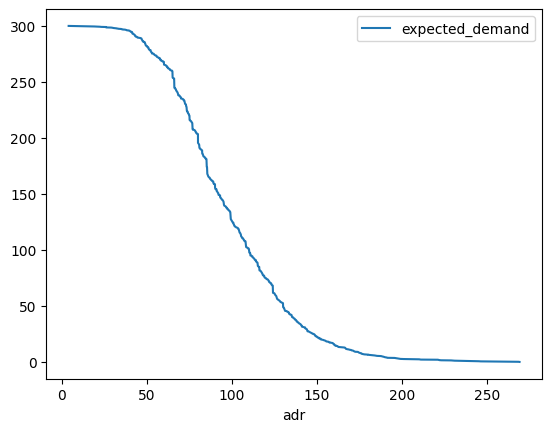

In [40]:
merged_df[(merged_df.dow == 'Friday') & (merged_df.month =='April')].plot(x='adr', y='expected_demand', kind='line')

<Axes: xlabel='adr'>

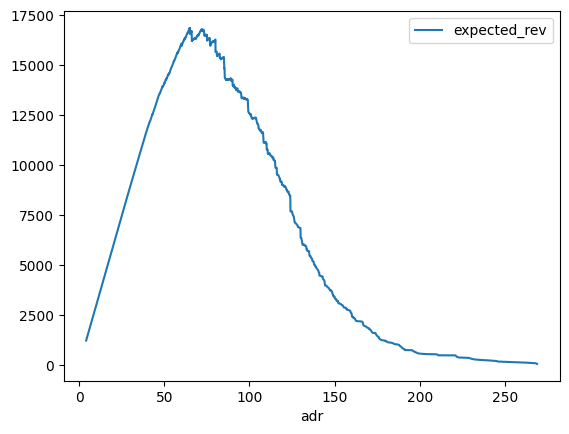

In [41]:
merged_df[(merged_df.dow == 'Friday') & (merged_df.month =='April')].plot(x='adr', y='expected_rev', kind='line')

In [42]:
from scipy.optimize import curve_fit

# Define the demand curve function
def demand_curve(x, a, b, c, d, max_demand):
    demand = a * np.exp(-b * x) + c
    demand = np.where(x <= max_demand, np.minimum(demand, max_demand), demand)
    return demand + d


In [43]:
x_data = merged_df['adr'].values
y_data = merged_df['expected_demand'].values


initial_guess = [1, 0.01, 1, 1, 100]
bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess)

a_fit, b_fit, c_fit ,d_fit,max_demand= params

In [44]:
predicted_demand = demand_curve(x_data, a_fit, b_fit,c_fit,d_fit,max_demand)

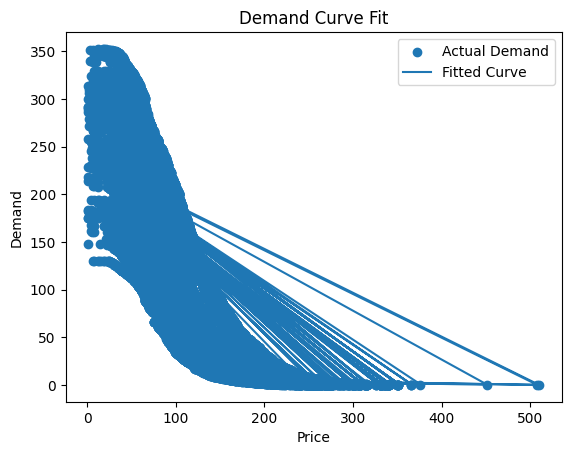

In [45]:
plt.scatter(x_data, y_data, label='Actual Demand')
plt.plot(x_data, predicted_demand, label='Fitted Curve')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.legend()
plt.title('Demand Curve Fit')
plt.show()

In [46]:
def revenue(price):
    return price * demand_curve(price, a_fit, b_fit,c_fit,d_fit,max_demand)

In [47]:
objective = lambda price: -revenue(price)
from scipy.optimize import minimize_scalar

result = minimize_scalar(objective, bounds=(60, 180), method='bounded')
optimal_price = result.x
max_revenue = -result.fun
room_sold = demand_curve(optimal_price, a_fit, b_fit,c_fit,d_fit,max_demand)

In [48]:
print(f"The optimal price to maximize revenue: ${optimal_price}")
print(f"The maximum revenue achievable: ${max_revenue}")
print(f"The expected number of rooms to sell: {room_sold}")

The optimal price to maximize revenue: $60.00000518697956
The maximum revenue achievable: $13350.082861472096
The expected number of rooms to sell: 222.50136178936802


In [49]:
from scipy.optimize import brentq

def demand_to_price(num_rooms, a, b, c, d, max_demand):
   
    def root_func(x):
        return num_rooms - (a * np.exp(-b * x) + c)
    
    # Find the price using numerical root finding
    price = brentq(root_func, 0, 200)  # Adjust the interval bounds as needed
    
    return price

In [50]:
demand_to_price(50,a_fit,b_fit,c_fit,d_fit,max_demand)

147.08787676141648

In [51]:
results = pd.DataFrame(columns=['month', 'dow', 'optimal_rate', 'expected_rn','expected_rev','optimal_rate_lim_inv'])

In [53]:
months = merged_df.month.unique()
dow = merged_df.dow.unique()

April Friday


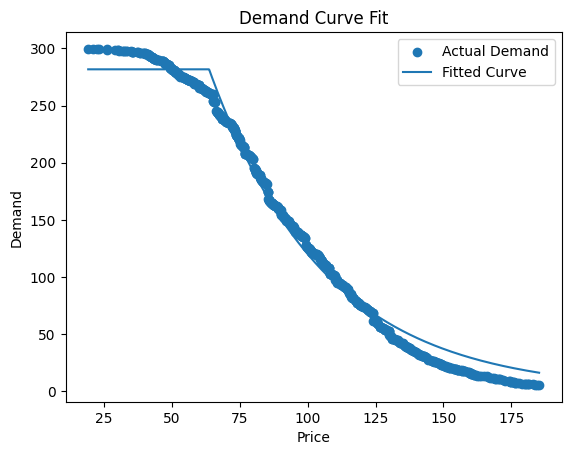

April Monday


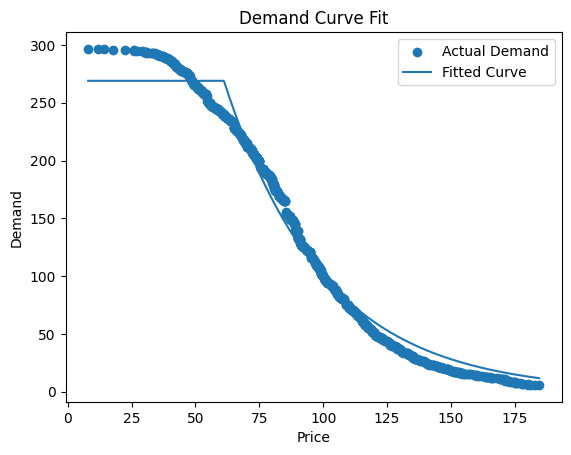

April Saturday


RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [54]:
#Create a loop to observe if our demand curve fits properly to each demand month and dow


for month in months:
    for day in dow:
        
        print(month,day)
        #get data
        data = merged_df[(merged_df.dow == day) & (merged_df.month ==month)].reset_index()
        
        #remove outlier
        mean = data.adr.mean()
        std_dev = data.adr.std()
       

        # calculate z-scores
        data['z_scores'] = np.abs((data.adr - mean) / std_dev)
        
        #filter out outliers
        data = data[data.z_scores <=2]
        
        ## Fit Demand curve
        x_data = data['adr'].values
        y_data = data['expected_demand'].values
        
        # Try except expression to ensure we get no errors when fitting the demand curve due to our initial guess
        try:
            initial_guess = [1, 0.01, 1, 1,data['rn_median'].values[0] ]
            bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

        # Fit the demand curve to the data
            params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess)
        except:
            if month =='January':
                
                initial_guess = [1, 0.01, 1, 1,40 ]
            else:
                initial_guess = [1, 0.01, 1, 1,50 ]
            bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

        # Fit the demand curve to the data
            params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess)
        
        # Extract the fitted parameters
        a_fit, b_fit, c_fit ,d_fit,max_demand= params
        
        #visually explore if the demand curve fits the data
        predicted_demand = demand_curve(x_data, a_fit, b_fit,c_fit,d_fit,max_demand)
        
        plt.scatter(x_data, y_data, label='Actual Demand')
        plt.plot(x_data, predicted_demand, label='Fitted Curve')
        plt.xlabel('Price')
        plt.ylabel('Demand')
        plt.legend()
        plt.title('Demand Curve Fit')
        plt.show()

In [ ]:
holidays_df = expanded_df.groupby(["hotel","room_type","arrival_date"]).agg({"total_rns": sum, "adr": np.mean,     "new_year": 'max',
    "easter": 'max',
    "christmas": 'max',
    "dow": 'first',
    "month": 'first'}).reset_index()

In [ ]:
holidays_df

In [ ]:
holidays_df['adr'] = np.round(holidays_df['adr'], 2)
holidays_df

In [ ]:
holidays_df[holidays_df['easter'] == 0]

In [ ]:
#holidays_df.columns = map(lambda x: str(x).upper(), holidays_df.columns)
#session.write_pandas(holidays_df, table_name="HOLIDAYS_DATASET", database=database, schema="TTH_REV_OPT_SCHEMA",  auto_create_table=True, overwrite=True)

In [ ]:
holidays_df.columns

In [ ]:
##PRICING MODEL 1 (WITHOUT HOLIDAYS)
#Remove holidays for our main model
non_holidays = expanded_df[expanded_df[['new_year', 'easter', 'christmas']].sum(axis=1) == 0]
non_holidays.head()

In [ ]:
final_dataset = pd.concat([non_holidays , holidays_df], axis=0).reset_index(drop=True)
final_dataset
#final_dataset.to_csv("./dataset_latest.csv",index=True)

In [ ]:
holidays_df.shape

In [ ]:
def add_rns(row):
    if row['hotel'] == 'City Hotel' and row['room_type'] == 'A':
        return 460
    elif row['hotel'] == 'City Hotel' and row['room_type'] == 'D':
        return 135
    elif row['hotel'] == 'City Hotel' and row['room_type'] == 'E':
        return 30
    elif row['hotel'] == 'Resort Hotel' and row['room_type'] == 'A':
        return 360
    elif row['hotel'] == 'Resort Hotel' and row['room_type'] == 'D':
        return 125
    elif row['hotel'] == 'Resort Hotel' and row['room_type'] == 'E':
        return 100

In [ ]:
final_dataset['dummy_rns'] = 0
final_dataset['dummy_rns'] = final_dataset.apply(add_rns, axis=1)

In [ ]:
final_dataset

In [ ]:
results = pd.DataFrame(columns=['month', 'dow', 'optimal_rate', 'expected_rn','expected_rev','optimal_rate_lim_inv'])


In [ ]:
daily_rns= non_holidays.groupby(['arrival_date','dow','month']).agg({'total_rns':'sum'}).reset_index() # get total stays per day
daily_rns = daily_rns.groupby(['dow','month']).agg({'total_rns':['sum','mean','median']}).reset_index() # get Rns metrics by Dow & Month
daily_rns.columns = ['_'.join(col) for col in daily_rns.columns] #remove multi level column
daily_rns

In [ ]:
adr_frequency = non_holidays.groupby(['dow','month','adr']).agg({'total_rns':'sum'})
adr_frequency.reset_index(inplace=True)
adr_frequency.head(10)


In [ ]:
merged_df = pd.merge(adr_frequency, daily_rns,how='left',left_on=['dow','month'], right_on=['dow_','month_'],suffixes=('_act', '_tot'))
merged_df = merged_df.drop(['dow_','month_'],axis=1)
merged_df

In [ ]:
merged_df['probability'] = merged_df['total_rns']/merged_df['total_rns_sum']
merged_df['expected_rns'] = merged_df['probability'] * merged_df['total_rns_median']

In [ ]:
merged_df = merged_df.sort_values(by=['dow', 'month', 'adr'], ascending=[True, True, False])
merged_df['expected_demand']=merged_df.groupby(['dow', 'month'])['expected_rns'].cumsum()
merged_df.head(10)

In [ ]:
results = pd.DataFrame(columns=['month', 'dow', 'optimal_rate', 'expected_rn','expected_rev','optimal_rate_lim_inv'])
months = merged_df.month.unique()
dow = merged_df.dow.unique()

In [ ]:
def demand_curve(x, a, b, c, d, max_demand):
    demand = a * np.exp(-b * x) + c
    demand = np.where(x <= max_demand, np.minimum(demand, max_demand), demand)
    return demand + d

def revenue(price):
    return price * demand_curve(price, a_fit, b_fit,c_fit,d_fit,max_demand)
from scipy.optimize import brentq

def demand_to_price(num_rooms, a, b, c, d, max_demand):
   
    def root_func(x):
        return num_rooms - (a * np.exp(-b * x) + c)
    
    # Find the price using numerical root finding
    price = brentq(root_func, 0, 200)  # Adjust the interval bounds as needed
    
    return price

In [ ]:
for month in months:
    for day in dow:
        data = merged_df[(merged_df.dow == day) & (merged_df.month ==month)].reset_index()
        mean = data.adr.mean()
        std_dev = data.adr.std()
        data['z_scores'] = np.abs((data.adr - mean) / std_dev)
        data = data[data.z_scores <=2]
        x_data = data['adr'].values
        y_data = data['expected_demand'].values
        try:
            initial_guess = [1, 0.01, 1, 1,data['total_rns_median'].values[0] ]
            bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])
            params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess)
        except:
            if month =='January':
                
                initial_guess = [1, 0.01, 1, 1,40 ]
            else:
                initial_guess = [1, 0.01, 1, 1,50 ]
            bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

            params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess)
        a_fit, b_fit, c_fit ,d_fit,max_demand= params
        
        predicted_demand = demand_curve(x_data, a_fit, b_fit,c_fit,d_fit,max_demand)
        
        plt.scatter(x_data, y_data, label='Actual Demand')
        plt.plot(x_data, predicted_demand, label='Fitted Curve')
        plt.xlabel('Price')
        plt.ylabel('Demand')
        plt.legend()
        plt.title('Demand Curve Fit')
        plt.show()


In [ ]:
for month in months:
    for day in dow:
        
      
        #get data
        data = merged_df[(merged_df.dow == day) & (merged_df.month ==month)].reset_index()
        
        #remove outlier
        mean = data.adr.mean()
        std_dev = data.adr.std()
       

        # calculate z-scores
        data['z_scores'] = np.abs((data.adr - mean) / std_dev)
        
        #filter out outliers
        data = data[data.z_scores <=2]
        
        ## Fit Demand curve
        x_data = data['adr'].values
        y_data = data['expected_demand'].values
        
        # Try except expression to ensure we get no errors when fitting the demand curve due to our initial guess
        try:
            initial_guess = [1, 0.01, 1, 1,data['total_rns_median'].values[0] ]
            bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

        # Fit the demand curve to the data
            params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess)
        except:
            if month =='January':
                
                initial_guess = [1, 0.01, 1, 1,40 ]
            else:
                initial_guess = [1, 0.01, 1, 1,50 ]
            bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

        # Fit the demand curve to the data
            params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess)
        
        # Extract the fitted parameters
        a_fit, b_fit, c_fit ,d_fit,max_demand= params
        
        #optimze revenue
        objective = lambda price: -revenue(price)
        
        

        optimize = minimize_scalar(objective, bounds=(45, 200), method='bounded')
        optimal_price = optimize.x
        max_revenue = -optimize.fun
        
        expected_rns = demand_curve(optimal_price,a_fit, b_fit, c_fit ,d_fit,max_demand)
        
        optimal_rate_lim_inv = demand_to_price(50,a_fit,b_fit,c_fit,d_fit,max_demand)
        
        new_row = pd.DataFrame({'month':month,
                        'dow':day,
                       'optimal_rate': optimal_price,
                       'expected_rev':max_revenue,
                       'expected_rn':expected_rns,
                       'optimal_rate_lim_inv':optimal_rate_lim_inv},index=[0])
        results = pd.concat([results, new_row], ignore_index=True)
        
results

In [ ]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

results['month'] = pd.Categorical(results['month'], categories=month_order, ordered=True)
results['dow'] = pd.Categorical(results['dow'], categories=dow_order, ordered=True)
results = results.sort_values(['month', 'dow'])

grouped = results.groupby(['month', 'dow'])['optimal_rate'].mean().unstack()

fig, ax = plt.subplots(figsize=(10, 6))
grouped.plot(ax=ax, kind='bar')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Optimal Rate')
ax.set_title('Optimal Rate by Month and Day of the Week')

plt.legend(title='Month', bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)

plt.show()
results

In [ ]:
results['optimal_rate'] = results['optimal_rate'].round()
results['optimal_rate_lim_inv'] = results['optimal_rate_lim_inv'].round()

results['expected_rn'] = results['expected_rn'].round().astype(int)
results['expected_rev'] = results['expected_rev'].round()


holidays =  expanded_df[expanded_df[['new_year', 'easter', 'christmas']].sum(axis=1) != 0]
holidays



In [ ]:
holidays

In [ ]:
unpivoted = pd.melt(holidays, id_vars=['total_rns', 'adr', 'dow', 'month'],
                    value_vars=['new_year', 'easter', 'christmas'],
                    var_name='holiday', value_name='holiday_indicator')
                    
unpivoted

In [ ]:
holiday_adr = unpivoted.groupby(['holiday','adr','holiday_indicator']).agg({'rn':'sum'}).reset_index()
holiday_rns = unpivoted.groupby(['optimal_rate','holiday',]).agg({'rn':'sum'}).reset_index()
holiday_rns = holiday_rns.groupby(['holiday']).agg({'rn':['sum','mean','median']}).reset_index()
holiday_rns.columns = ['_'.join(col) for col in holiday_rns.columns]

merged_holidays = pd.merge(holiday_adr, holiday_rns,how='left',left_on=['holiday'], right_on=['holiday_'],suffixes=('_act', '_tot'))
merged_holidays.drop('holiday_',axis=1,inplace=True)
merged_holidays